In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2 as pg
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [11]:
#what is performed when querying the database. For sample purposes, we will read data from a sample csv
try:
    conn=pg.connect("dbname='footballstats' user='rschen1' password='' host = 'fantasytweets.ckjgi4dhbxfi.us-east-2.rds.amazonaws.com' port = '5432'")
except:
    print("I am unable to connect to the database.")
cur = conn.cursor()

We see in the below graph that the number of quarterbacks in the NFL by PLayer Year experiences significant dropoff over time. Our initial intuitiion was that this was due to players' decrease in performance over time. This intuition is what made us interested in using a time series model to predict players' performances. 

Text(0, 0.5, 'Number of Games Played')

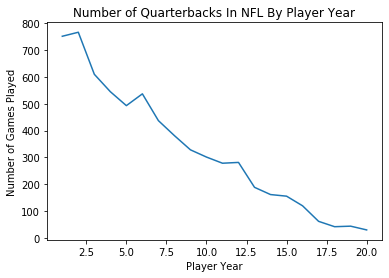

In [16]:
qb_dist = pd.read_csv('qb_by_year.csv')
qb_dist = qb_dist.sort_values('player_year')
plt.plot(qb_dist['player_year'], qb_dist['count'])
plt.title('Number of Quarterbacks In NFL By Player Year')
plt.xlabel('Player Year')
plt.ylabel('Number of Games Played')

In [17]:
season_qb_df = pd.read_csv('season_qb.csv')

In this dataset, we can see that when comparing the best quarterbacks by experience, it seems to hold that players perform worse over time. This was another factor that supported the idea of using a time series model to predict player performance. 

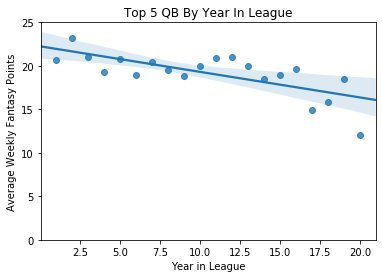

In [20]:
top_season_qb_df = season_qb_df.sort_values(['PlayerYear', 'FantPt'], ascending=False).groupby('PlayerYear').head(5)
top_season_qb_df = top_season_qb_df.groupby('PlayerYear',as_index=False)['FantPt'].mean()
top_season_qb_df['PlayerYear'] = top_season_qb_df.index + 1
sns.regplot(top_season_qb_df['PlayerYear'], top_season_qb_df['FantPt'])
plt.title('Top 5 QB By Year In League')
plt.xlabel('Year in League')
plt.ylabel('Average Weekly Fantasy Points')
plt.ylim([0, 25])
plt.savefig('TopQBFantPtByYear.jpg')

In [2]:
qb = pd.read_csv('qb_sample_data.csv')
qb_separated = [pd.DataFrame(y) for x, y in qb.groupby('name', as_index=False)]

In [3]:
#Only taking quarterbacks with more than 3 years of data to analyze quarterback performnace over time
qb_data = []
for i in qb_separated: 
    if len(i) > 3: 
        qb_data.append(i)

In [4]:
#ARIMA Model
predicted_values = []
actual_values = []
for qb_year in qb_data: 
    try:
        qb_year = qb_year.sort_values('year')
        #run first-differencing to induce stationarity
        qb_year['diff_fant_pt'] = qb_year['avg_fant_pt'].diff()
        qb_year['diff_fant_pt'].fillna(0, inplace=True)
        train_data = qb_year[:len(qb_year)-1]
        test_data = qb_year[len(qb_year)-1:]
        model = ARIMA(train_data['diff_fant_pt'], order = (1,0,0))
        result = model.fit()
        predictions = result.predict(0, 0, typ = 'levels').rename('Predictions')
        predicted_values.append(predictions.values[0])
        actual_values.append(test_data['diff_fant_pt'].values[0])
    except:
        pass

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsup

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inver

This model is predicting a player's difference in fantasy points from the previous year to the next year using the player's entire career statistics.

In [5]:
#deleting strong outlier in dataset, unsure why predicted value is so high at index 40 only
del predicted_values[40]
del actual_values[40]

QB mean squared error: 47.20586856852274
QB Root mean squared error: 6.870652703238808


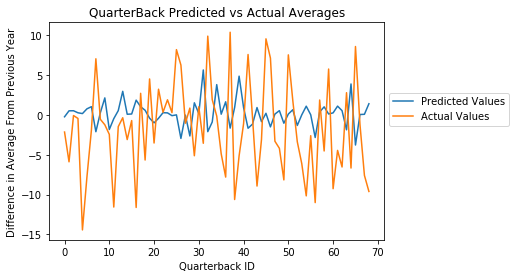

In [6]:
plt.title('QuarterBack Predicted vs Actual Averages')
plt.plot(predicted_values, label='Predicted Values')
plt.plot(actual_values, label='Actual Values')
plt.xlabel('Quarterback ID')
plt.ylabel('Difference in Average From Previous Year')
plt.legend(loc='best', bbox_to_anchor=[1, 0.7])

In [21]:
print('QB Mean squared error:', mean_squared_error(predicted_values, actual_values))
print('QB Root mean squared error:', rmse(predicted_values, actual_values))

QB Mean squared error: 47.20586856852274
QB Root mean squared error: 6.870652703238808
